In [1]:
import mat73
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statistics as stat
import os
import tqdm
import math

In [2]:
def flatten_spect(df):
    flattened_features = pd.DataFrame(np.stack(np.asarray(df["spect"].apply(lambda x: x.flatten())), axis=0))
    df_flattened = pd.concat(
        [df.drop(columns=["spect"]).reset_index(drop=True), flattened_features.reset_index(drop=True)],
        axis=1)
    return df_flattened

def load_dataframe():
    data_dict = mat73.loadmat('spect_phee2monkey_mel_cell_nopadding_streched_50x50.mat')
    data_dict["spect"] = [data_dict["spect"][:, :, i] for i in range(data_dict["spect"].shape[2])]
    df = pd.DataFrame(data_dict)
    for name in ['callee', 'caller', 'expname']:
        df[name] = df[name].apply(lambda x: x[0])
    df.loc[df["callee"] == "Brhama", "callee"] = "Brahma"
    df.loc[df["caller"] == "Brhama", "caller"] = "Brahma"
    dates_str = df["expname"].astype("string").apply(lambda x: x.replace("exp_", "")[:10])
    df["date"] = pd.to_datetime(dates_str, format='%Y_%m_%d')
    return flatten_spect(df)

def show_cm(cmn, title, labels):
    fig, ax = plt.subplots(figsize=(15, 15))
    f = sns.heatmap(cmn, annot=True, fmt=".1%", linewidths=1.0, square=1)
    plt.title(title, fontsize=25)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    _ = ax.set_xticklabels(labels)
    _ = plt.xticks(rotation=70)
    _ = ax.set_yticklabels(labels)
    _ = plt.yticks(rotation=0)
    plt.show()


def display_mean_conf_mat(conf_mats, labels, title):
    mean_conf_mat = np.mean(conf_mats, axis=0)
    fig, ax = plt.subplots(figsize=(15, 15))
    f = sns.heatmap(mean_conf_mat, annot=True, fmt=".1%", linewidths=1.0, square=1)
    plt.title(title, fontsize=25)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    _ = ax.set_xticklabels(labels)
    _ = plt.xticks(rotation=70)
    _ = ax.set_yticklabels(labels)
    _ = plt.yticks(rotation=0)
    return mean_conf_mat

In [3]:
def get_caller_average_spect(df):
    callers_avg_spect = {}
    for caller in df["caller"].unique():
        caller_df = df[df["caller"] == caller].drop(columns=['callee','caller','expname','expnameid','date'])
        avg_spectrogram = caller_df.mean(axis=0)

        # Calculate the Euclidean distance for each spectrogram and get the minimum
        min_distance = np.inf
        most_similar_spectrogram = None
        for i, row in caller_df.iterrows():
            distance = np.linalg.norm(row - avg_spectrogram)
            if distance < min_distance:
                min_distance = distance
                most_similar_spectrogram = row

        matrix = most_similar_spectrogram.values.reshape(50,50)
        avg_caller_spect = pd.DataFrame(matrix)
        callers_avg_spect[caller] = avg_caller_spect

    return callers_avg_spect


In [4]:
df = load_dataframe()

In [5]:
df = df[df['caller'] != "Brahma"]
df = df[df['caller'] != "Chaos"]

C:\Users\Tomer\AppData\Local\Temp\ipykernel_18708\1743659310.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(axs[row, col].imshow(avg_spect, aspect='auto', cmap='inferno', origin='lower'), ax=axs[row, col], format='%+2.0f dB')


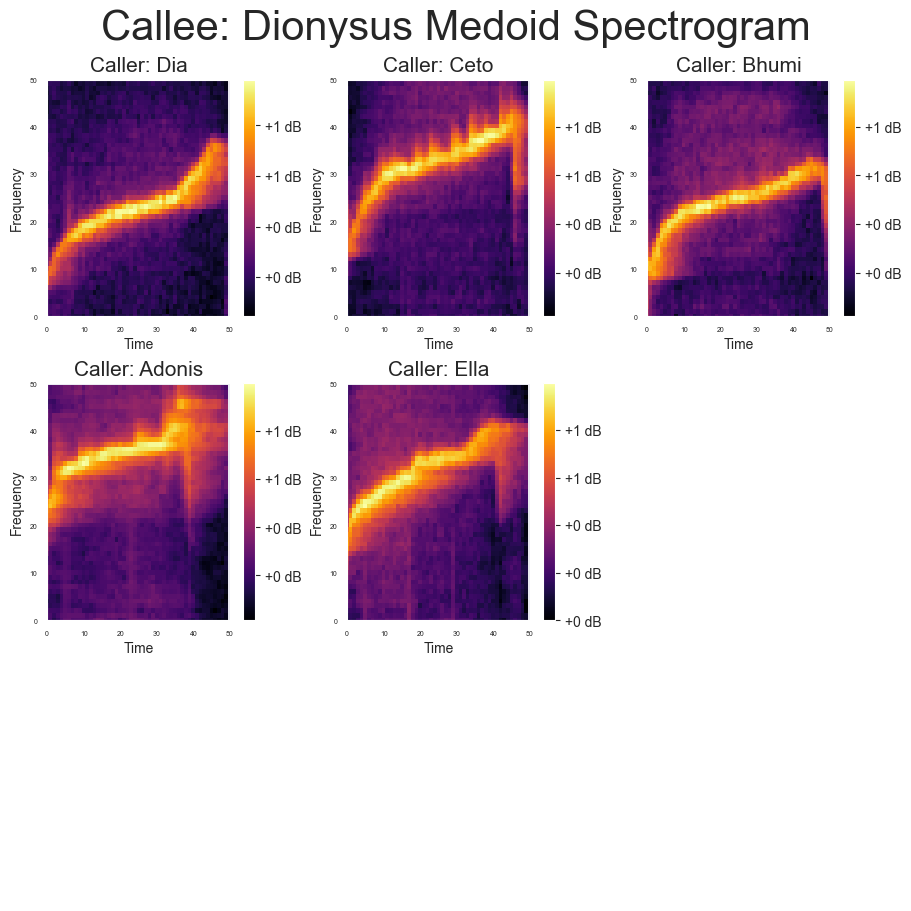

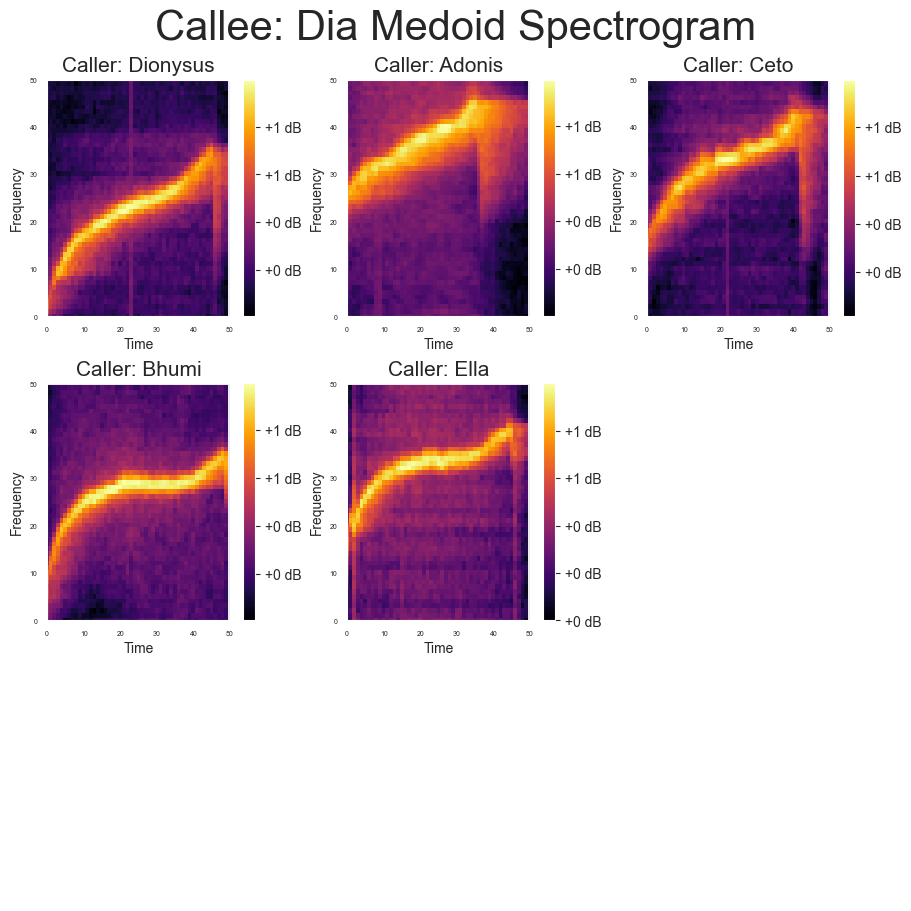

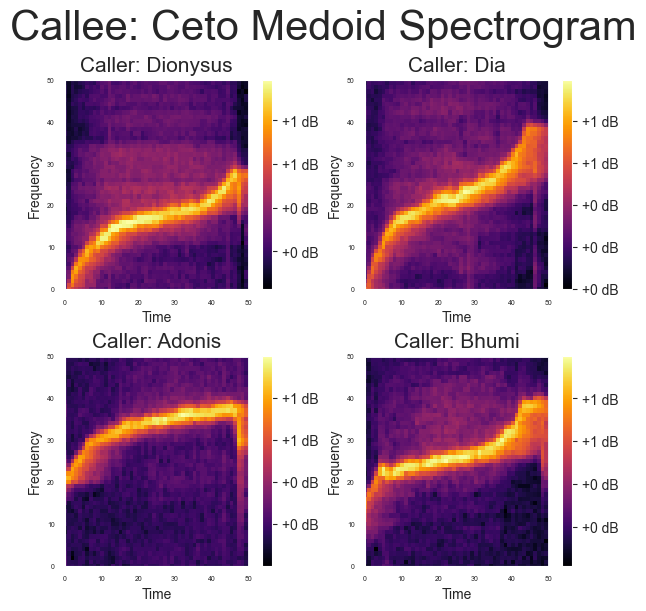

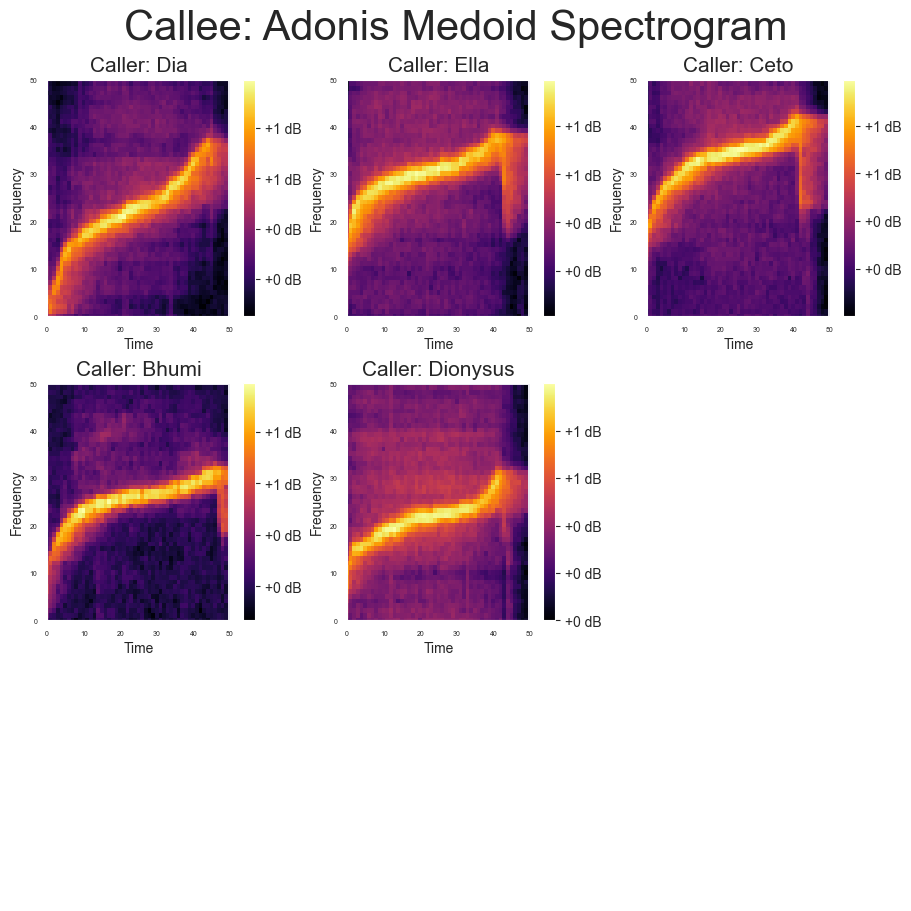

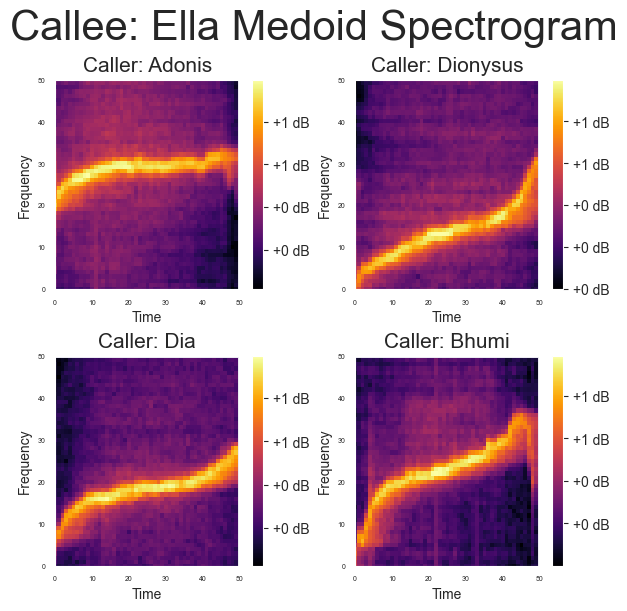

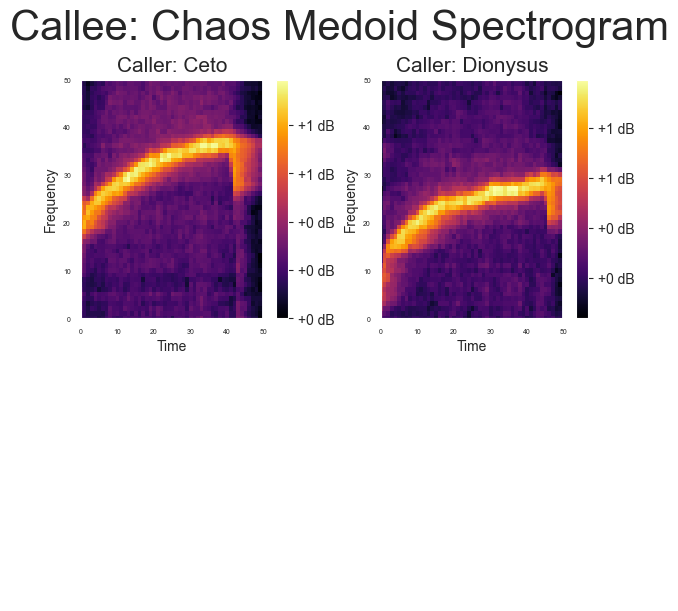

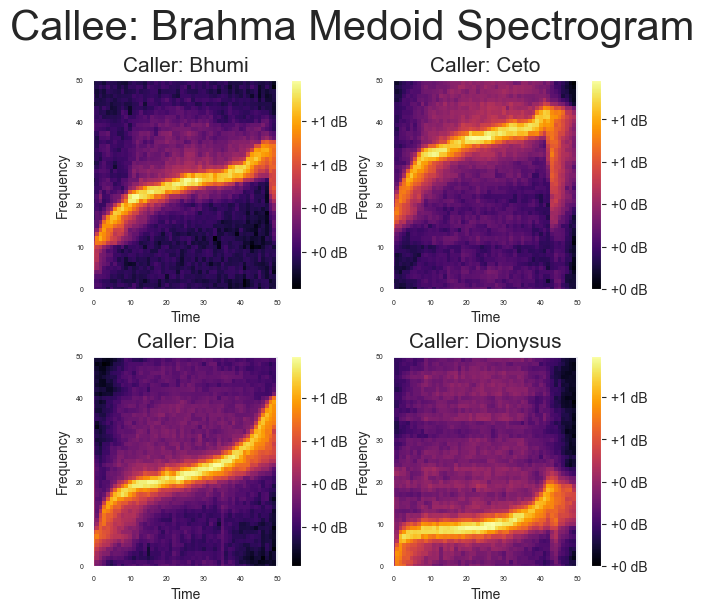

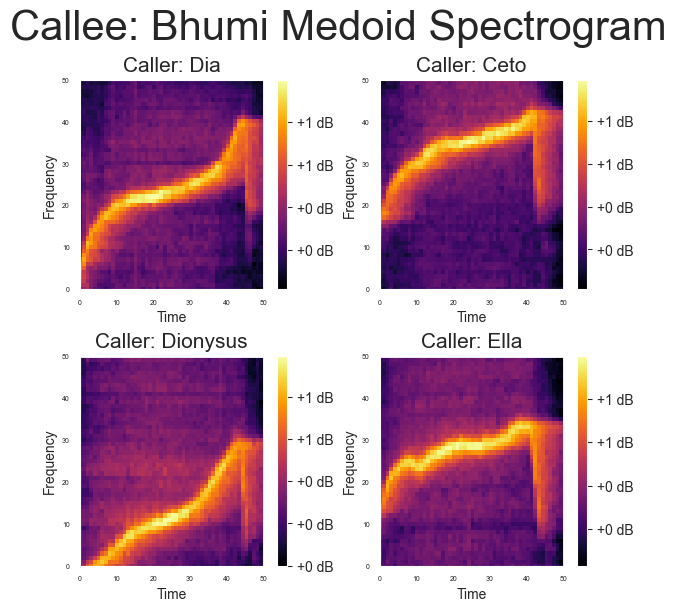

In [8]:
def plot_delta_to_corr(callers_avg_spect, callee):
    num_plots = len(callers_avg_spect)
    num_cols = math.ceil(math.sqrt(num_plots))
    num_rows = math.ceil(num_plots / num_cols)
    max_axis = max(num_cols,num_rows)
    fig, axs = plt.subplots(max_axis, max_axis, figsize=(3 * max_axis,3 * max_axis), constrained_layout = True)
    fig.suptitle(f"Callee: {callee} Medoid Spectrogram", fontsize=30)

    for row in range(max_axis):
        for col in range(max_axis):
            axs[row,col].set_axis_off()

    for i, (caller, avg_spect) in enumerate(callers_avg_spect.items()):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].set_axis_on()
        axs[row, col].imshow(avg_spect, aspect='auto', cmap='inferno', origin='lower')
        axs[row, col].set_title(f"Caller: {caller}", fontsize=15)
        axs[row, col].set_xlabel('Time', fontsize=10)
        axs[row, col].set_ylabel('Frequency', fontsize=10)
        axs[row, col].tick_params(axis='both', which='major', labelsize=5)
        axs[row, col].set_xlim([0, 50])
        axs[row, col].set_ylim([0, 50])
        axs[row, col].grid(False)
        fig.colorbar(axs[row, col].imshow(avg_spect, aspect='auto', cmap='inferno', origin='lower'), ax=axs[row, col], format='%+2.0f dB')

    directory = 'images'
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(directory+f"/Callee {callee} Medoid Spectrogram.png",format='png')

    plt.show()


for callee in df["callee"].unique():
    callers_avg_spect = get_caller_average_spect(df.loc[df["callee"] == callee])
    plot_delta_to_corr(callers_avg_spect, callee)